In [1]:
# source: https://www.kaggle.com/nadintamer/titanic-survival-predictions-beginner

# Titanic Survival Predictions (Beginner)
# I am a newbie to data science and machine learning, and will be attempting to work my way through the Titanic: Machine Learning from Disaster dataset. Please consider upvoting if this is useful to you! :)

### Contents:
# 1. Import Necessary Libraries
# 2. Read In and Explore the Data
# 3. Data Analysis
# 4. Data Visualization
# 5. Cleaning Data
# 6. Choosing the Best Model
# 7. Creating Submission File

# Any and all feedback is welcome! 

## 1) Import Necessary Libraries
First off, we need to import several Python libraries such as numpy, pandas, matplotlib and seaborn.

In [2]:
#data analysis libraries 
import numpy as np
import pandas as pd

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb

## 2) Read in and Explore the Data 
It's time to read in our training and testing data using `pd.read_csv`, and take a first look at the training data using the `describe()` function.

In [3]:

color = sns.color_palette()
sns.set_style('darkgrid')
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import norm, skew #for some statistics

#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 


# Read and expolore the data
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

#take a look at the training data
train.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000,891.000,891.000,891,891,714.000,891.000,891.000,891,891.000,204,889
unique,nan,nan,nan,891,2,nan,nan,nan,681,nan,147,3
top,nan,nan,nan,"Stankovic, Mr. Ivan",male,nan,nan,nan,347082,nan,B96 B98,S
freq,nan,nan,nan,1,577,nan,nan,nan,7,nan,4,644
mean,446.000,0.384,2.309,NaN,NaN,29.699,0.523,0.382,NaN,32.204,NaN,NaN
std,257.354,0.487,0.836,NaN,NaN,14.526,1.103,0.806,NaN,49.693,NaN,NaN
min,1.000,0.000,1.000,NaN,NaN,0.420,0.000,0.000,NaN,0.000,NaN,NaN
25%,223.500,0.000,2.000,NaN,NaN,20.125,0.000,0.000,NaN,7.910,NaN,NaN
50%,446.000,0.000,3.000,NaN,NaN,28.000,0.000,0.000,NaN,14.454,NaN,NaN
75%,668.500,1.000,3.000,NaN,NaN,38.000,1.000,0.000,NaN,31.000,NaN,NaN


## 3) Data Analysis
We're going to consider the features in the dataset and how complete they are. 

In [4]:
#get a list of the features within the dataset
print(train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [5]:
#see a sample of the dataset to get an idea of the variables
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
252,253,0,1,"Stead, Mr. William Thomas",male,62.000,0,0,113514,26.550,C87,S
773,774,0,3,"Elias, Mr. Dibo",male,nan,0,0,2674,7.225,NaN,C
447,448,1,1,"Seward, Mr. Frederic Kimber",male,34.000,0,0,113794,26.550,NaN,S
766,767,0,1,"Brewe, Dr. Arthur Jackson",male,nan,0,0,112379,39.600,NaN,C
495,496,0,3,"Yousseff, Mr. Gerious",male,nan,0,0,2627,14.458,NaN,C


* **Numerical Features:** Age (Continuous), Fare (Continuous), SibSp (Discrete), Parch (Discrete)
* **Categorical Features:** Survived, Sex, Embarked, Pclass
* **Alphanumeric Features:** Ticket, Cabin

#### What are the data types for each feature?
* Survived: int
* Pclass: int
* Name: string
* Sex: string
* Age: float
* SibSp: int
* Parch: int
* Ticket: string
* Fare: float
* Cabin: string
* Embarked: string

Now that we have an idea of what kinds of features we're working with, we can see how much information we have about each of them.


In [6]:
#see a summary of the training dataset
train.describe(include = "all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000,891.000,891.000,891,891,714.000,891.000,891.000,891,891.000,204,889
unique,nan,nan,nan,891,2,nan,nan,nan,681,nan,147,3
top,nan,nan,nan,"Stankovic, Mr. Ivan",male,nan,nan,nan,347082,nan,B96 B98,S
freq,nan,nan,nan,1,577,nan,nan,nan,7,nan,4,644
mean,446.000,0.384,2.309,NaN,NaN,29.699,0.523,0.382,NaN,32.204,NaN,NaN
std,257.354,0.487,0.836,NaN,NaN,14.526,1.103,0.806,NaN,49.693,NaN,NaN
min,1.000,0.000,1.000,NaN,NaN,0.420,0.000,0.000,NaN,0.000,NaN,NaN
25%,223.500,0.000,2.000,NaN,NaN,20.125,0.000,0.000,NaN,7.910,NaN,NaN
50%,446.000,0.000,3.000,NaN,NaN,28.000,0.000,0.000,NaN,14.454,NaN,NaN
75%,668.500,1.000,3.000,NaN,NaN,38.000,1.000,0.000,NaN,31.000,NaN,NaN


#### Some Observations:
* There are a total of 891 passengers in our training set.
* The Age feature is missing approximately 19.8% of its values. I'm guessing that the Age feature is pretty important to survival, so we should probably attempt to fill these gaps. 
* The Cabin feature is missing approximately 77.1% of its values. Since so much of the feature is missing, it would be hard to fill in the missing values. We'll probably drop these values from our dataset.
* The Embarked feature is missing 0.22% of its values, which should be relatively harmless.

In [7]:
#check for any other unusable values
print(pd.isnull(train).sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


We can see that except for the abovementioned missing values, no NaN values exist.

### Some Predictions:
* Sex: Females are more likely to survive.
* SibSp/Parch: People traveling alone are more likely to survive.
* Age: Young children are more likely to survive.
* Pclass: People of higher socioeconomic class are more likely to survive.

## 4) Data Visualization
It's time to visualize our data so we can see whether our predictions were accurate! 

### Sex Feature

Percentage of females who survived: 74.2038216561
Percentage of males who survived: 18.8908145581


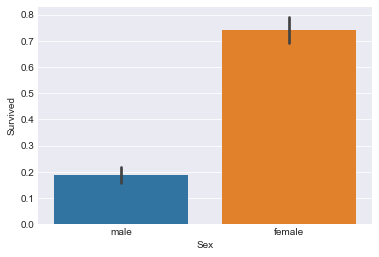

In [8]:
#draw a bar plot of survival by sex
sns.barplot(x="Sex", y="Survived", data=train)

#print percentages of females vs. males that survive
print("Percentage of females who survived:", train["Survived"][train["Sex"] == 'female'].value_counts(normalize = True)[1]*100)

print("Percentage of males who survived:", train["Survived"][train["Sex"] == 'male'].value_counts(normalize = True)[1]*100)

As predicted, females have a much higher chance of survival than males. The Sex feature is essential in our predictions.

### Pclass Feature

Percentage of Pclass = 1 who survived: 62.962962963
Percentage of Pclass = 2 who survived: 47.2826086957
Percentage of Pclass = 3 who survived: 24.2362525458


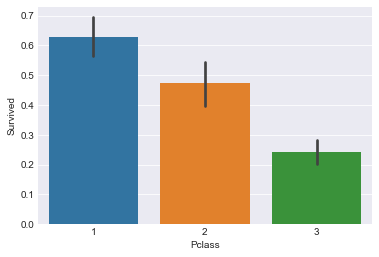

In [9]:
#draw a bar plot of survival by Pclass
sns.barplot(x="Pclass", y="Survived", data=train)

#print percentage of people by Pclass that survived
print("Percentage of Pclass = 1 who survived:", train["Survived"][train["Pclass"] == 1].value_counts(normalize = True)[1]*100)

print("Percentage of Pclass = 2 who survived:", train["Survived"][train["Pclass"] == 2].value_counts(normalize = True)[1]*100)

print("Percentage of Pclass = 3 who survived:", train["Survived"][train["Pclass"] == 3].value_counts(normalize = True)[1]*100)

As predicted, people with higher socioeconomic class had a higher rate of survival. (62.9% vs. 47.3% vs. 24.2%)

### SibSp Feature

Percentage of SibSp = 0 who survived: 34.5394736842
Percentage of SibSp = 1 who survived: 53.5885167464
Percentage of SibSp = 2 who survived: 46.4285714286


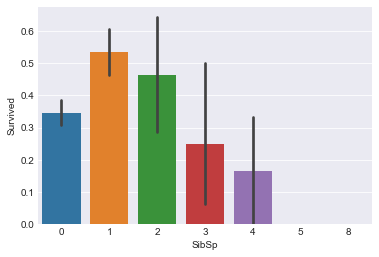

In [10]:
#draw a bar plot for SibSp vs. survival
sns.barplot(x="SibSp", y="Survived", data=train)

#I won't be printing individual percent values for all of these.
print("Percentage of SibSp = 0 who survived:", train["Survived"][train["SibSp"] == 0].value_counts(normalize = True)[1]*100)

print("Percentage of SibSp = 1 who survived:", train["Survived"][train["SibSp"] == 1].value_counts(normalize = True)[1]*100)

print("Percentage of SibSp = 2 who survived:", train["Survived"][train["SibSp"] == 2].value_counts(normalize = True)[1]*100)

In general, it's clear that people with more siblings or spouses aboard were less likely to survive. However, contrary to expectations, people with no siblings or spouses were less to likely to survive than those with one or two. (34.5% vs 53.4% vs. 46.4%)

### Parch Feature

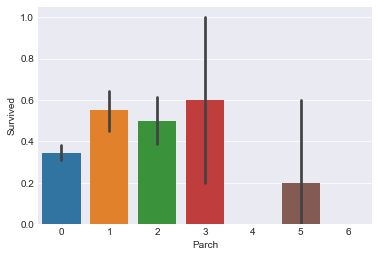

In [11]:
#draw a bar plot for Parch vs. survival
sns.barplot(x="Parch", y="Survived", data=train)
plt.show()

People with less than four parents or children aboard are more likely to survive than those with four or more. Again, people traveling alone are less likely to survive than those with 1-3 parents or children.

### Age Feature

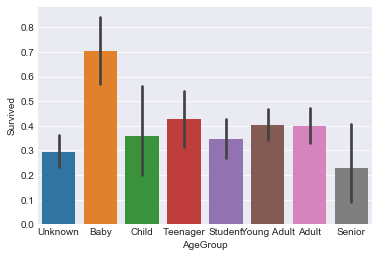

In [12]:
#sort the ages into logical categories
train["Age"] = train["Age"].fillna(-0.5)
test["Age"] = test["Age"].fillna(-0.5)
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
train['AgeGroup'] = pd.cut(train["Age"], bins, labels = labels)
test['AgeGroup'] = pd.cut(test["Age"], bins, labels = labels)

#draw a bar plot of Age vs. survival
sns.barplot(x="AgeGroup", y="Survived", data=train)
plt.show()

Babies are more likely to survive than any other age group. 

### Cabin Feature
I think the idea here is that people with recorded cabin numbers are of higher socioeconomic class, and thus more likely to survive. Thanks for the tips, [@salvus82](https://www.kaggle.com/salvus82) and [Daniel Ellis](https://www.kaggle.com/dellis83)!

Percentage of CabinBool = 1 who survived: 66.6666666667
Percentage of CabinBool = 0 who survived: 29.9854439592


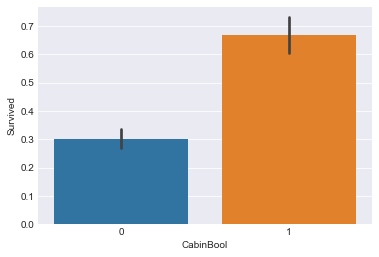

In [13]:
train["CabinBool"] = (train["Cabin"].notnull().astype('int'))
test["CabinBool"] = (test["Cabin"].notnull().astype('int'))

#calculate percentages of CabinBool vs. survived
print("Percentage of CabinBool = 1 who survived:", train["Survived"][train["CabinBool"] == 1].value_counts(normalize = True)[1]*100)

print("Percentage of CabinBool = 0 who survived:", train["Survived"][train["CabinBool"] == 0].value_counts(normalize = True)[1]*100)
#draw a bar plot of CabinBool vs. survival
sns.barplot(x="CabinBool", y="Survived", data=train)
plt.show()

People with a recorded Cabin number are, in fact, more likely to survive. (66.6% vs 29.9%)

## 5) Cleaning Data
Time to clean our data to account for missing values and unnecessary information!

### Looking at the Test Data
Let's see how our test data looks!

In [14]:
test.describe(include="all")

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeGroup,CabinBool
count,418.000,418.000,418,418,418.000,418.000,418.000,418,417.000,91,418,418,418.000
unique,nan,nan,418,2,nan,nan,nan,363,nan,76,3,8,nan
top,nan,nan,"Carlsson, Mr. Carl Robert",male,nan,nan,nan,PC 17608,nan,B57 B59 B63 B66,S,Young Adult,nan
freq,nan,nan,1,266,nan,nan,nan,5,nan,3,270,96,nan
mean,1100.500,2.266,NaN,NaN,23.941,0.447,0.392,NaN,35.627,NaN,NaN,NaN,0.218
std,120.810,0.842,NaN,NaN,17.741,0.897,0.981,NaN,55.908,NaN,NaN,NaN,0.413
min,892.000,1.000,NaN,NaN,-0.500,0.000,0.000,NaN,0.000,NaN,NaN,NaN,0.000
25%,996.250,1.000,NaN,NaN,9.000,0.000,0.000,NaN,7.896,NaN,NaN,NaN,0.000
50%,1100.500,3.000,NaN,NaN,24.000,0.000,0.000,NaN,14.454,NaN,NaN,NaN,0.000
75%,1204.750,3.000,NaN,NaN,35.750,1.000,0.000,NaN,31.500,NaN,NaN,NaN,0.000


* We have a total of 418 passengers.
* 1 value from the Fare feature is missing.
* Around 20.5% of the Age feature is missing, we will need to fill that in.

### Cabin Feature

In [15]:
#we'll start off by dropping the Cabin feature since not a lot more useful information can be extracted from it.
train = train.drop(['Cabin'], axis = 1)
test = test.drop(['Cabin'], axis = 1)

### Ticket Feature

In [16]:
#we can also drop the Ticket feature since it's unlikely to yield any useful information
train = train.drop(['Ticket'], axis = 1)
test = test.drop(['Ticket'], axis = 1)

### Embarked Feature

In [17]:
#now we need to fill in the missing values in the Embarked feature
print("Number of people embarking in Southampton (S):")
southampton = train[train["Embarked"] == "S"].shape[0]
print(southampton)

print("Number of people embarking in Cherbourg (C):")
cherbourg = train[train["Embarked"] == "C"].shape[0]
print(cherbourg)

print("Number of people embarking in Queenstown (Q):")
queenstown = train[train["Embarked"] == "Q"].shape[0]
print(queenstown)

Number of people embarking in Southampton (S):
644
Number of people embarking in Cherbourg (C):
168
Number of people embarking in Queenstown (Q):
77


It's clear that the majority of people embarked in Southampton (S). Let's go ahead and fill in the missing values with S.

In [18]:
#replacing the missing values in the Embarked feature with S
train = train.fillna({"Embarked": "S"})

### Age Feature

Next we'll fill in the missing values in the Age feature. Since a higher percentage of values are missing, it would be illogical to fill all of them with the same value (as we did with Embarked). Instead, let's try to find a way to predict the missing ages. 

In [19]:
#create a combined group of both datasets
combine = [train, test]

#extract a title for each Name in the train and test datasets
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [20]:
#replace various titles with more common names
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Capt', 'Col',
    'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')
    
    dataset['Title'] = dataset['Title'].replace(['Countess', 'Lady', 'Sir'], 'Royal')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575
1,Miss,0.703
2,Mr,0.157
3,Mrs,0.794
4,Rare,0.286
5,Royal,1.000


In [21]:
#map each of the title groups to a numerical value
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Royal": 5, "Rare": 6}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeGroup,CabinBool,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,7.250,S,Student,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,71.283,C,Adult,1,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,7.925,S,Young Adult,0,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,53.100,S,Young Adult,1,3
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,8.050,S,Young Adult,0,1


The code I used above is from [here](https://www.kaggle.com/startupsci/titanic-data-science-solutions). Next, we'll try to predict the missing Age values from the most common age for their Title.

In [22]:
# fill missing age with mode age group for each title
mr_age = train[train["Title"] == 1]["AgeGroup"].mode() #Young Adult
miss_age = train[train["Title"] == 2]["AgeGroup"].mode() #Student
mrs_age = train[train["Title"] == 3]["AgeGroup"].mode() #Adult
master_age = train[train["Title"] == 4]["AgeGroup"].mode() #Baby
royal_age = train[train["Title"] == 5]["AgeGroup"].mode() #Adult
rare_age = train[train["Title"] == 6]["AgeGroup"].mode() #Adult

age_title_mapping = {1: "Young Adult", 2: "Student", 3: "Adult", 4: "Baby", 5: "Adult", 6: "Adult"}

#I tried to get this code to work with using .map(), but couldn't.
#I've put down a less elegant, temporary solution for now.
#train = train.fillna({"Age": train["Title"].map(age_title_mapping)})
#test = test.fillna({"Age": test["Title"].map(age_title_mapping)})

for x in range(len(train["AgeGroup"])):
    if train["AgeGroup"][x] == "Unknown":
        train["AgeGroup"][x] = age_title_mapping[train["Title"][x]]
        
for x in range(len(test["AgeGroup"])):
    if test["AgeGroup"][x] == "Unknown":
        test["AgeGroup"][x] = age_title_mapping[test["Title"][x]]

Now that we've filled in the missing values at least *somewhat* accurately (I will work on a better way for predicting missing age values), it's time to map each age group to a numerical value.

In [23]:
#map each Age value to a numerical value
age_mapping = {'Baby': 1, 'Child': 2, 'Teenager': 3, 'Student': 4, 'Young Adult': 5, 'Adult': 6, 'Senior': 7}
train['AgeGroup'] = train['AgeGroup'].map(age_mapping)
test['AgeGroup'] = test['AgeGroup'].map(age_mapping)

train.head()

#dropping the Age feature for now, might change
train = train.drop(['Age'], axis = 1)
test = test.drop(['Age'], axis = 1)

### Name Feature
We can drop the name feature now that we've extracted the titles.

In [24]:
#drop the name feature since it contains no more useful information.
train = train.drop(['Name'], axis = 1)
test = test.drop(['Name'], axis = 1)

### Sex Feature

In [25]:
#map each Sex value to a numerical value
sex_mapping = {"male": 0, "female": 1}
train['Sex'] = train['Sex'].map(sex_mapping)
test['Sex'] = test['Sex'].map(sex_mapping)

train.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,AgeGroup,CabinBool,Title
0,1,0,3,0,1,0,7.250,S,4,0,1
1,2,1,1,1,1,0,71.283,C,6,1,3
2,3,1,3,1,0,0,7.925,S,5,0,2
3,4,1,1,1,1,0,53.100,S,5,1,3
4,5,0,3,0,0,0,8.050,S,5,0,1


### Embarked Feature

In [26]:
#map each Embarked value to a numerical value
embarked_mapping = {"S": 1, "C": 2, "Q": 3}
train['Embarked'] = train['Embarked'].map(embarked_mapping)
test['Embarked'] = test['Embarked'].map(embarked_mapping)

train.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,AgeGroup,CabinBool,Title
0,1,0,3,0,1,0,7.250,1,4,0,1
1,2,1,1,1,1,0,71.283,2,6,1,3
2,3,1,3,1,0,0,7.925,1,5,0,2
3,4,1,1,1,1,0,53.100,1,5,1,3
4,5,0,3,0,0,0,8.050,1,5,0,1


### Fare Feature
It's time separate the fare values into some logical groups as well as filling in the single missing value in the test dataset.

In [27]:
#fill in missing Fare value in test set based on mean fare for that Pclass 
for x in range(len(test["Fare"])):
    if pd.isnull(test["Fare"][x]):
        pclass = test["Pclass"][x] #Pclass = 3
        test["Fare"][x] = round(train[train["Pclass"] == pclass]["Fare"].mean(), 4)
        
#map Fare values into groups of numerical values
train['FareBand'] = pd.qcut(train['Fare'], 4, labels = [1, 2, 3, 4])
train = train.fillna({"FareBand": 2})

test['FareBand'] = pd.qcut(test['Fare'], 4, labels = [1, 2, 3, 4])

#drop Fare values
train = train.drop(['Fare'], axis = 1)
test = test.drop(['Fare'], axis = 1)


In [28]:
# df[['col2','col3']].apply(pd.to_numeric)
# train['FareBand'].describe()
train['FareBand'] = train['FareBand'].astype(int)
test['FareBand'] = test['FareBand'].astype(int)
test['FareBand'].describe()

count   418.000
mean      2.474
std       1.140
min       1.000
25%       1.000
50%       2.000
75%       3.750
max       4.000
Name: FareBand, dtype: float64

In [29]:
#check train data
train.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Embarked,AgeGroup,CabinBool,Title,FareBand
0,1,0,3,0,1,0,1,4,0,1,1
1,2,1,1,1,1,0,2,6,1,3,4
2,3,1,3,1,0,0,1,5,0,2,2
3,4,1,1,1,1,0,1,5,1,3,4
4,5,0,3,0,0,0,1,5,0,1,2


In [30]:
#check test data
test.head()

,PassengerId,Pclass,Sex,SibSp,Parch,Embarked,AgeGroup,CabinBool,Title,FareBand
0,892,3,0,0,0,3,5,0,1,1
1,893,3,1,1,0,1,6,0,3,1
2,894,2,0,0,0,3,7,0,1,2
3,895,3,0,0,0,1,5,0,1,2
4,896,3,1,1,1,1,4,0,3,2


## 6) Choosing the Best Model

### Splitting the Training Data
We will use part of our training data (22% in this case) to test the accuracy of our different models.

In [31]:
from sklearn.model_selection import train_test_split

predictors = train.drop(['Survived', 'PassengerId'], axis=1)
target = train["Survived"]
x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.22, random_state = 0)

### Testing Different Models
I will be testing the following models with my training data (got the list from [here](http://https://www.kaggle.com/startupsci/titanic-data-science-solutions)):
* Gaussian Naive Bayes
* Logistic Regression
* Support Vector Machines
* Perceptron
* Decision Tree Classifier
* Random Forest Classifier
* KNN or k-Nearest Neighbors
* Stochastic Gradient Descent
* Gradient Boosting Classifier

For each model, we set the model, fit it with 80% of our training data, predict for 20% of the training data and check the accuracy.

In [32]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
y_pred = gaussian.predict(x_val)
acc_gaussian = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gaussian)

78.68


In [33]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_val)
acc_logreg = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_logreg)

79.19


In [34]:
# Support Vector Machines
from sklearn.svm import SVC

svc = SVC()
svc.fit(x_train, y_train)
y_pred = svc.predict(x_val)
acc_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_svc)

82.74


In [35]:
# Linear SVC
from sklearn.svm import LinearSVC

linear_svc = LinearSVC()
linear_svc.fit(x_train, y_train)
y_pred = linear_svc.predict(x_val)
acc_linear_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_linear_svc)

78.17


In [36]:
# Perceptron
from sklearn.linear_model import Perceptron

perceptron = Perceptron()
perceptron.fit(x_train, y_train)
y_pred = perceptron.predict(x_val)
acc_perceptron = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_perceptron)

79.19


In [37]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

decisiontree = DecisionTreeClassifier()
decisiontree.fit(x_train, y_train)
y_pred = decisiontree.predict(x_val)
acc_decisiontree = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_decisiontree)

80.2


In [38]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier()
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_val)
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_randomforest)

83.76


In [39]:
# KNN or k-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_val)
acc_knn = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_knn)

77.66


In [40]:
# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_val)
acc_sgd = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_sgd)

76.65


In [94]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

gbk = GradientBoostingClassifier()
gbk.fit(x_train, y_train)
y_pred = gbk.predict(x_val)
acc_gbk = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gbk)

84.77


In [83]:
import xgboost as xgb
# clf = XGBClassifier()
10/1
# 'max_depth': [3,5,7], 'min_child_weight': [1,3,5]
model_xgb = xgb.XGBClassifier(base_score=0.5, 
                              colsample_bylevel=1, 
                              colsample_bytree=1,
                              gamma=0, 
                              learning_rate=0.01, 
                              max_delta_step=0, 
                              max_depth=10,
                              min_child_weight=1, 
                              missing=None, 
                              n_estimators=1000, 
                              nthread=-1,
                              objective='binary:logistic', 
                              reg_alpha=0, 
                              reg_lambda=1,
                              scale_pos_weight=1,
                              seed=0, 
#                               silent=True, 
                              subsample=1)


# model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
#                              learning_rate=0.05, max_depth=3, 
#                              min_child_weight=1.7817, n_estimators=2200,
#                              reg_alpha=0.4640, reg_lambda=0.8571,
#                              subsample=0.5213, silent=1,
#                              random_state =7, nthread = -1)


model_xgb.fit(x_train, y_train)
xgb_train_pred = model_xgb.predict(x_val)

acc_xgb = accuracy_score(xgb_train_pred.round(), y_val, normalize=True) * 100
print(acc_xgb)

85.2791878173


In [84]:
# model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
#                               learning_rate=0.05, n_estimators=720,
#                               max_bin = 55, bagging_fraction = 0.8,
#                               bagging_freq = 5, feature_fraction = 0.2319,
#                               feature_fraction_seed=9, bagging_seed=9,
#                               min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

# model_lgb.fit(x_train, y_train)
# lgb_train_pred = model_xgb.predict(x_val)
# lgb_pred = model_xgb.predict(x_val)

# accuracy_score(lgb_pred.round(), y_val, normalize=True) * 100


Let's compare the accuracies of each model!

In [85]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 'Linear SVC', 
              'Decision Tree', 'Stochastic Gradient Descent', 'Gradient Boosting Classifier',
              'XGB'],
    'Score': [acc_svc, acc_knn, acc_logreg, 
              acc_randomforest, acc_gaussian, acc_perceptron,acc_linear_svc, acc_decisiontree,
              acc_sgd, acc_gbk, acc_xgb]})
models.sort_values(by='Score', ascending=False)

,Model,Score
10,XGB,85.279
9,Gradient Boosting Classifier,84.770
3,Random Forest,83.760
0,Support Vector Machines,82.740
7,Decision Tree,80.200
2,Logistic Regression,79.190
5,Perceptron,79.190
4,Naive Bayes,78.680
6,Linear SVC,78.170
1,KNN,77.660


I decided to use the Random Forest model for the testing data.

## 7) Creating Submission File
It's time to create a submission.csv file to upload to the Kaggle competition!

In [96]:
#set ids as PassengerId and predict survival 
ids = test['PassengerId']
# predictions = gbk.predict(test.drop('PassengerId', axis=1))

# # Retrain of full dataset
gbk = GradientBoostingClassifier()
gbk.fit(predictors, target)
predictions = gbk.predict(test.drop('PassengerId', axis=1))



# predictions = model_xgb.predict(test.drop('PassengerId', axis=1))
#set the output as a dataframe and convert to csv file named submission.csv
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.to_csv('submission.csv', index=False)

In [92]:
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


If you've come this far, congratulations and thank you for reading! 

*If you use any part of this notebook in a published kernel, credit (you can simply link back here) would be greatly appreciated. :)*

## Sources:
* [Titanic Data Science Solutions](https://www.kaggle.com/startupsci/titanic-data-science-solutions)
* [Scikit-Learn ML from Start to Finish](https://www.kaggle.com/jeffd23/scikit-learn-ml-from-start-to-finish?scriptVersionId=320209)

Any and all feedback is welcome! 